In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


devise = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 32
learning_rate = 1e-3
weight_decay = 1e-4
T_max = 10

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = torchvision.datasets.CIFAR100(root='./cifar100',
                                           download=True,
                                           transform=transform,
                                           train=True)

test_dataset = torchvision.datasets.CIFAR100(root='./cifar100',
                                             download=True,
                                             transform=transform_test,
                                             train=False)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


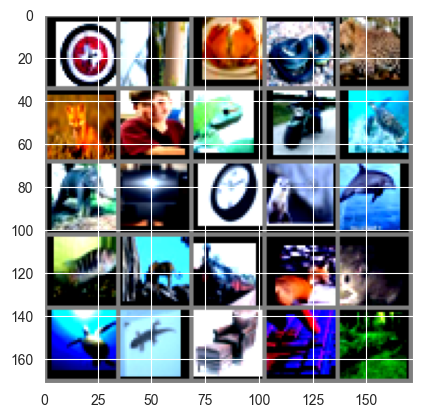

In [15]:

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=8)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)


def showimg(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
showimg(img_grid)

In [16]:
class Cifar100Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )
        self.aap2 = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 100)
        )

    def forward(self, x):
            out = self.conv(x)
            out = self.aap2(out)
            out = torch.flatten(out, 1)
            out = self.lin(out)
            return out


In [17]:

model = Cifar100Conv()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

n_total_steps = len(train_loader);

for epoch in range(T_max):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        outputs = model(images)

        l = criterion(outputs, labels)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += l

    scheduler.step()
    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Training finished')
PATH = './CIFAR100.pth'
torch.save(model.state_dict(), PATH)

[1] loss: 4.035
[2] loss: 3.583
[3] loss: 3.309
[4] loss: 3.094
[5] loss: 2.949
[6] loss: 2.825
[7] loss: 2.723
[8] loss: 2.636
[9] loss: 2.550
[10] loss: 2.486
Training finished


In [18]:
load_model = Cifar100Conv()
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()


    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test image: {100*acc}%')


Accuracy of the network on the 10000 test image: 31.630000000000003%
